In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import imageio

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cpu


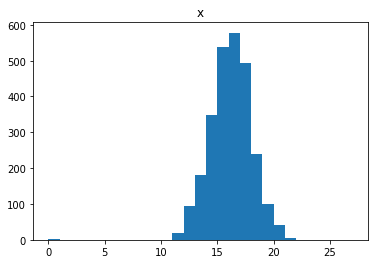

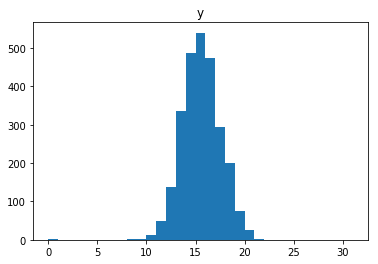

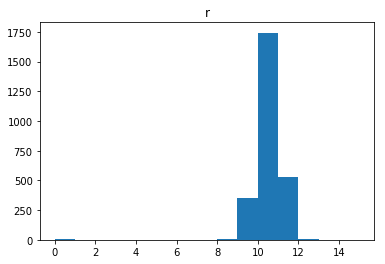

(2639, 1, 1, 280, 320)
(2639, 3, 1)


In [3]:
#load images
import glob

def load_pics():
    pics = glob.glob('CASIA-Iris-Interval/**/*.jpg', recursive=True)

    X = []
    names = []
    for pic in pics:
        f = imageio.imread(pic)/255.0
        X.append(f)
        names.append(pic[-12:])
    
    X = np.array(X)
    return X, names

#load annotations
def load_annotations(X, order):
    N = X.shape[0]
    f = open('CASIA-Iris-V3-Labels.txt')
    y_trunc = np.zeros((N, 3)) 
    y_true = np.zeros((N,3))
    for l in f:
        l = l.strip().split(' ')
        name, a, b, c = l[0], int(l[1]), int(l[2]), int(l[3])
        i = order.index(name)
        y_true[i] += np.array([a, b, c])
        y_trunc[i] += np.array([a // 10, b // 10, c // 10])
    return y_true, y_trunc
    
X, order = load_pics()
Xt = np.array(X).reshape((X.shape[0], 1, 1, X.shape[1], X.shape[2]))
y_true, y = load_annotations(X, order)

plt.hist(y[:,0], bins=range(28))
plt.title('x')
plt.show()

plt.hist(y[:,1], bins=range(32))
plt.title('y')
plt.show()

plt.hist(y[:,2], bins=range(16))
plt.title('r')
plt.show()

yt = y.reshape((y.shape[0], y.shape[1], 1))

print(Xt.shape)
print(yt.shape)

In [4]:
N = Xt.shape[0]
train = int(6*N/10)
val = int(7*N/10)
X_train = Xt[:train]
X_val = Xt[train:val]
X_test = Xt[val:]

y_train = yt[:train]
y_train_true = y_true[:train]

y_val = yt[train:val]
y_val_true = y_true[train:val]

y_test = yt[val:]
y_test_true = y_true[val:]

X_train = torch.tensor(X_train).type(torch.FloatTensor)
y_train = torch.tensor(y_train)

X_val = torch.tensor(X_val).type(torch.FloatTensor)
y_val = torch.tensor(y_val)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

torch.Size([1583, 1, 1, 280, 320])
torch.Size([1583, 3, 1])
torch.Size([264, 1, 1, 280, 320])
torch.Size([264, 3, 1])


In [5]:
def check_accuracy_part34(mode, model, param):
    
    def assign_param(param, y_generic):
        if param == 'x':
            return y_generic[:,0]
        elif param == 'y':
            return y_generic[:,1]
        else:
            return y_generic[:,2]
    
    if mode == 'val':
        X_sel = X_val
        y_sel = assign_param(param, y_val)
    elif mode == 'train':
        X_sel = X_train
        y_sel = assign_param(param, y_train)
    else:
        X_sel = X_test
        y_sel = assign_param(param, y_test)
        
    SE = 0.0
    num_correct = 0
    num_samples = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t in range(X_sel.shape[0]):
            
            x = X_sel[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #SE += (x_center.data[0][0] - y) ** 2
            
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) for mode %s' % (num_correct, num_samples, 100 * acc, mode))
        #print(('RMSE ->', SE))

In [6]:
def train_part34(model, optimizer, param, epochs=20):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    if param == 'x':
        y_sel = y_train[:,0]
    elif param == 'y':
        y_sel = y_train[:,1]
    else:
        y_sel = y_train[:,2]
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        #for t, (x, y) in enumerate(training_data):
        for t in range(X_train.shape[0]):
            model.train()  # put model to training mode
            
            x = X_train[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            #x_center = model(x)
            #loss = F.mse_loss(x_center[0][0], y)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print() 
        
        print('epoch %d' % (e))
        check_accuracy_part34('train', model, param)
        check_accuracy_part34('val', model, param)
        print() 

In [7]:
def flatten(x):
    return x.view(x.shape[0] , -1)

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [9]:
channel_1 = 32
channel_2 = 16

model_x = nn.Sequential(
    nn.MaxPool2d(kernel_size=10, stride=10, padding=0),
    nn.Conv2d(1, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(672, 28)
)

model_y = nn.Sequential(
    nn.MaxPool2d(kernel_size=10, stride=10, padding=0),
    nn.Conv2d(1, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(672, 32)
)

model_r = nn.Sequential(
    nn.MaxPool2d(kernel_size=10, stride=10, padding=0),
    nn.Conv2d(1, channel_1, kernel_size=5, padding=0, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(672, 14)
)

optimizer_x = optim.SGD(model_x.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer_y = optim.SGD(model_y.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer_r = optim.SGD(model_r.parameters(), lr=1e-4, momentum=0.9, nesterov=True)

print('Train X Position')
train_part34(model_x, optimizer_x, 'x', epochs=200)

print('Train Y Position')
train_part34(model_y, optimizer_y, 'y', epochs=200)

print('Train Radius')
train_part34(model_r, optimizer_r, 'r', epochs=200)

Train X Position
Iteration 0, loss = 3.2876

Iteration 500, loss = 1.9067

Iteration 1000, loss = 1.4999

Iteration 1500, loss = 1.2143

epoch 0
Got 330 / 1583 correct (20.85) for mode train
Got 57 / 264 correct (21.59) for mode val

Iteration 0, loss = 1.5850

Iteration 500, loss = 1.7639

Iteration 1000, loss = 1.4825

Iteration 1500, loss = 1.1722

epoch 1
Got 330 / 1583 correct (20.85) for mode train
Got 57 / 264 correct (21.59) for mode val

Iteration 0, loss = 1.5136

Iteration 500, loss = 1.7093

Iteration 1000, loss = 1.4743

Iteration 1500, loss = 1.1558

epoch 2
Got 335 / 1583 correct (21.16) for mode train
Got 59 / 264 correct (22.35) for mode val

Iteration 0, loss = 1.4509

Iteration 500, loss = 1.6602

Iteration 1000, loss = 1.4614

Iteration 1500, loss = 1.1352

epoch 3
Got 397 / 1583 correct (25.08) for mode train
Got 70 / 264 correct (26.52) for mode val

Iteration 0, loss = 1.3669

Iteration 500, loss = 1.5971

Iteration 1000, loss = 1.4277

Iteration 1500, loss = 1.1

Iteration 1500, loss = 0.0957

epoch 37
Got 1242 / 1583 correct (78.46) for mode train
Got 188 / 264 correct (71.21) for mode val

Iteration 0, loss = 0.0151

Iteration 500, loss = 0.3561

Iteration 1000, loss = 0.0063

Iteration 1500, loss = 0.0865

epoch 38
Got 1245 / 1583 correct (78.65) for mode train
Got 188 / 264 correct (71.21) for mode val

Iteration 0, loss = 0.0137

Iteration 500, loss = 0.3552

Iteration 1000, loss = 0.0058

Iteration 1500, loss = 0.0785

epoch 39
Got 1248 / 1583 correct (78.84) for mode train
Got 186 / 264 correct (70.45) for mode val

Iteration 0, loss = 0.0123

Iteration 500, loss = 0.3428

Iteration 1000, loss = 0.0054

Iteration 1500, loss = 0.0707

epoch 40
Got 1257 / 1583 correct (79.41) for mode train
Got 185 / 264 correct (70.08) for mode val

Iteration 0, loss = 0.0110

Iteration 500, loss = 0.3355

Iteration 1000, loss = 0.0050

Iteration 1500, loss = 0.0635

epoch 41
Got 1261 / 1583 correct (79.66) for mode train
Got 185 / 264 correct (70.08) for

Iteration 500, loss = 0.1451

Iteration 1000, loss = 0.0037

Iteration 1500, loss = 0.0117

epoch 75
Got 1325 / 1583 correct (83.70) for mode train
Got 180 / 264 correct (68.18) for mode val

Iteration 0, loss = 0.0018

Iteration 500, loss = 0.1389

Iteration 1000, loss = 0.0037

Iteration 1500, loss = 0.0117

epoch 76
Got 1326 / 1583 correct (83.77) for mode train
Got 180 / 264 correct (68.18) for mode val

Iteration 0, loss = 0.0018

Iteration 500, loss = 0.1338

Iteration 1000, loss = 0.0039

Iteration 1500, loss = 0.0117

epoch 77
Got 1329 / 1583 correct (83.95) for mode train
Got 180 / 264 correct (68.18) for mode val

Iteration 0, loss = 0.0019

Iteration 500, loss = 0.1296

Iteration 1000, loss = 0.0037

Iteration 1500, loss = 0.0112

epoch 78
Got 1334 / 1583 correct (84.27) for mode train
Got 182 / 264 correct (68.94) for mode val

Iteration 0, loss = 0.0021

Iteration 500, loss = 0.1285

Iteration 1000, loss = 0.0037

Iteration 1500, loss = 0.0110

epoch 79
Got 1334 / 1583 cor

Iteration 1500, loss = 0.0108

epoch 112
Got 1465 / 1583 correct (92.55) for mode train
Got 186 / 264 correct (70.45) for mode val

Iteration 0, loss = 0.0257

Iteration 500, loss = 0.0264

Iteration 1000, loss = 0.0012

Iteration 1500, loss = 0.0104

epoch 113
Got 1466 / 1583 correct (92.61) for mode train
Got 185 / 264 correct (70.08) for mode val

Iteration 0, loss = 0.0260

Iteration 500, loss = 0.0242

Iteration 1000, loss = 0.0011

Iteration 1500, loss = 0.0094

epoch 114
Got 1468 / 1583 correct (92.74) for mode train
Got 186 / 264 correct (70.45) for mode val

Iteration 0, loss = 0.0264

Iteration 500, loss = 0.0225

Iteration 1000, loss = 0.0011

Iteration 1500, loss = 0.0091

epoch 115
Got 1468 / 1583 correct (92.74) for mode train
Got 186 / 264 correct (70.45) for mode val

Iteration 0, loss = 0.0284

Iteration 500, loss = 0.0221

Iteration 1000, loss = 0.0011

Iteration 1500, loss = 0.0097

epoch 116
Got 1470 / 1583 correct (92.86) for mode train
Got 185 / 264 correct (70.08

Got 1528 / 1583 correct (96.53) for mode train
Got 190 / 264 correct (71.97) for mode val

Iteration 0, loss = 0.0230

Iteration 500, loss = 0.0034

Iteration 1000, loss = 0.0002

Iteration 1500, loss = 0.0019

epoch 150
Got 1529 / 1583 correct (96.59) for mode train
Got 190 / 264 correct (71.97) for mode val

Iteration 0, loss = 0.0215

Iteration 500, loss = 0.0033

Iteration 1000, loss = 0.0002

Iteration 1500, loss = 0.0019

epoch 151
Got 1528 / 1583 correct (96.53) for mode train
Got 191 / 264 correct (72.35) for mode val

Iteration 0, loss = 0.0200

Iteration 500, loss = 0.0032

Iteration 1000, loss = 0.0002

Iteration 1500, loss = 0.0019

epoch 152
Got 1528 / 1583 correct (96.53) for mode train
Got 192 / 264 correct (72.73) for mode val

Iteration 0, loss = 0.0187

Iteration 500, loss = 0.0030

Iteration 1000, loss = 0.0002

Iteration 1500, loss = 0.0018

epoch 153
Got 1528 / 1583 correct (96.53) for mode train
Got 192 / 264 correct (72.73) for mode val

Iteration 0, loss = 0.017

Iteration 500, loss = 0.0005

Iteration 1000, loss = 0.0000

Iteration 1500, loss = 0.0011

epoch 187
Got 1559 / 1583 correct (98.48) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0048

Iteration 500, loss = 0.0005

Iteration 1000, loss = 0.0000

Iteration 1500, loss = 0.0010

epoch 188
Got 1559 / 1583 correct (98.48) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0047

Iteration 500, loss = 0.0005

Iteration 1000, loss = 0.0000

Iteration 1500, loss = 0.0011

epoch 189
Got 1559 / 1583 correct (98.48) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0046

Iteration 500, loss = 0.0004

Iteration 1000, loss = 0.0000

Iteration 1500, loss = 0.0010

epoch 190
Got 1559 / 1583 correct (98.48) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0045

Iteration 500, loss = 0.0004

Iteration 1000, loss = 0.0000

Iteration 1500, loss = 0.0011

epoch 191
Got 1559 / 158

Iteration 1500, loss = 1.4893

epoch 24
Got 1199 / 1583 correct (75.74) for mode train
Got 189 / 264 correct (71.59) for mode val

Iteration 0, loss = 0.0363

Iteration 500, loss = 1.3229

Iteration 1000, loss = 0.0887

Iteration 1500, loss = 1.4743

epoch 25
Got 1203 / 1583 correct (75.99) for mode train
Got 189 / 264 correct (71.59) for mode val

Iteration 0, loss = 0.0359

Iteration 500, loss = 1.3256

Iteration 1000, loss = 0.0835

Iteration 1500, loss = 1.4787

epoch 26
Got 1210 / 1583 correct (76.44) for mode train
Got 187 / 264 correct (70.83) for mode val

Iteration 0, loss = 0.0356

Iteration 500, loss = 1.3228

Iteration 1000, loss = 0.0798

Iteration 1500, loss = 1.4592

epoch 27
Got 1216 / 1583 correct (76.82) for mode train
Got 187 / 264 correct (70.83) for mode val

Iteration 0, loss = 0.0359

Iteration 500, loss = 1.3226

Iteration 1000, loss = 0.0755

Iteration 1500, loss = 1.4424

epoch 28
Got 1216 / 1583 correct (76.82) for mode train
Got 188 / 264 correct (71.21) for

Iteration 500, loss = 1.0717

Iteration 1000, loss = 0.0281

Iteration 1500, loss = 0.7222

epoch 62
Got 1290 / 1583 correct (81.49) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0646

Iteration 500, loss = 1.0566

Iteration 1000, loss = 0.0271

Iteration 1500, loss = 0.7113

epoch 63
Got 1287 / 1583 correct (81.30) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0648

Iteration 500, loss = 1.0525

Iteration 1000, loss = 0.0265

Iteration 1500, loss = 0.6847

epoch 64
Got 1289 / 1583 correct (81.43) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0648

Iteration 500, loss = 1.0408

Iteration 1000, loss = 0.0254

Iteration 1500, loss = 0.6760

epoch 65
Got 1294 / 1583 correct (81.74) for mode train
Got 194 / 264 correct (73.48) for mode val

Iteration 0, loss = 0.0646

Iteration 500, loss = 1.0533

Iteration 1000, loss = 0.0247

Iteration 1500, loss = 0.6566

epoch 66
Got 1293 / 1583 cor

Iteration 1500, loss = 0.3097

epoch 99
Got 1351 / 1583 correct (85.34) for mode train
Got 192 / 264 correct (72.73) for mode val

Iteration 0, loss = 0.0752

Iteration 500, loss = 0.6255

Iteration 1000, loss = 0.0079

Iteration 1500, loss = 0.2935

epoch 100
Got 1354 / 1583 correct (85.53) for mode train
Got 190 / 264 correct (71.97) for mode val

Iteration 0, loss = 0.0785

Iteration 500, loss = 0.6247

Iteration 1000, loss = 0.0078

Iteration 1500, loss = 0.2988

epoch 101
Got 1350 / 1583 correct (85.28) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0788

Iteration 500, loss = 0.6387

Iteration 1000, loss = 0.0076

Iteration 1500, loss = 0.2913

epoch 102
Got 1354 / 1583 correct (85.53) for mode train
Got 193 / 264 correct (73.11) for mode val

Iteration 0, loss = 0.0786

Iteration 500, loss = 0.6218

Iteration 1000, loss = 0.0077

Iteration 1500, loss = 0.2976

epoch 103
Got 1358 / 1583 correct (85.79) for mode train
Got 192 / 264 correct (72.73)

Got 1404 / 1583 correct (88.69) for mode train
Got 189 / 264 correct (71.59) for mode val

Iteration 0, loss = 0.2153

Iteration 500, loss = 0.2071

Iteration 1000, loss = 0.0063

Iteration 1500, loss = 0.1403

epoch 137
Got 1409 / 1583 correct (89.01) for mode train
Got 188 / 264 correct (71.21) for mode val

Iteration 0, loss = 0.2152

Iteration 500, loss = 0.2020

Iteration 1000, loss = 0.0064

Iteration 1500, loss = 0.1398

epoch 138
Got 1406 / 1583 correct (88.82) for mode train
Got 189 / 264 correct (71.59) for mode val

Iteration 0, loss = 0.2184

Iteration 500, loss = 0.1930

Iteration 1000, loss = 0.0061

Iteration 1500, loss = 0.1397

epoch 139
Got 1409 / 1583 correct (89.01) for mode train
Got 189 / 264 correct (71.59) for mode val

Iteration 0, loss = 0.2101

Iteration 500, loss = 0.1867

Iteration 1000, loss = 0.0062

Iteration 1500, loss = 0.1269

epoch 140
Got 1418 / 1583 correct (89.58) for mode train
Got 187 / 264 correct (70.83) for mode val

Iteration 0, loss = 0.164

Iteration 500, loss = 0.0617

Iteration 1000, loss = 0.0198

Iteration 1500, loss = 0.0264

epoch 174
Got 1472 / 1583 correct (92.99) for mode train
Got 188 / 264 correct (71.21) for mode val

Iteration 0, loss = 0.0739

Iteration 500, loss = 0.0608

Iteration 1000, loss = 0.0198

Iteration 1500, loss = 0.0250

epoch 175
Got 1472 / 1583 correct (92.99) for mode train
Got 187 / 264 correct (70.83) for mode val

Iteration 0, loss = 0.0724

Iteration 500, loss = 0.0526

Iteration 1000, loss = 0.0227

Iteration 1500, loss = 0.0233

epoch 176
Got 1474 / 1583 correct (93.11) for mode train
Got 188 / 264 correct (71.21) for mode val

Iteration 0, loss = 0.0661

Iteration 500, loss = 0.0513

Iteration 1000, loss = 0.0213

Iteration 1500, loss = 0.0231

epoch 177
Got 1474 / 1583 correct (93.11) for mode train
Got 188 / 264 correct (71.21) for mode val

Iteration 0, loss = 0.0646

Iteration 500, loss = 0.0484

Iteration 1000, loss = 0.0208

Iteration 1500, loss = 0.0214

epoch 178
Got 1475 / 158

Iteration 1000, loss = 1.9440

Iteration 1500, loss = 0.0586

epoch 11
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.1521

Iteration 500, loss = 0.2099

Iteration 1000, loss = 1.9401

Iteration 1500, loss = 0.0593

epoch 12
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.1711

Iteration 500, loss = 0.2088

Iteration 1000, loss = 1.9348

Iteration 1500, loss = 0.0605

epoch 13
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.1909

Iteration 500, loss = 0.2079

Iteration 1000, loss = 1.9342

Iteration 1500, loss = 0.0622

epoch 14
Got 1078 / 1583 correct (68.10) for mode train
Got 168 / 264 correct (63.64) for mode val

Iteration 0, loss = 3.2031

Iteration 500, loss = 0.2078

Iteration 1000, loss = 1.9299

Iteration 1500, loss = 0.0642

epoch 15
Got 1078 / 1583 correct (68.10) for mode train
Go

Got 1125 / 1583 correct (71.07) for mode train
Got 172 / 264 correct (65.15) for mode val

Iteration 0, loss = 3.1639

Iteration 500, loss = 0.3712

Iteration 1000, loss = 2.2404

Iteration 1500, loss = 0.0618

epoch 49
Got 1130 / 1583 correct (71.38) for mode train
Got 172 / 264 correct (65.15) for mode val

Iteration 0, loss = 3.1574

Iteration 500, loss = 0.3654

Iteration 1000, loss = 2.2784

Iteration 1500, loss = 0.0600

epoch 50
Got 1133 / 1583 correct (71.57) for mode train
Got 172 / 264 correct (65.15) for mode val

Iteration 0, loss = 3.1461

Iteration 500, loss = 0.3526

Iteration 1000, loss = 2.3217

Iteration 1500, loss = 0.0615

epoch 51
Got 1134 / 1583 correct (71.64) for mode train
Got 172 / 264 correct (65.15) for mode val

Iteration 0, loss = 3.1377

Iteration 500, loss = 0.3461

Iteration 1000, loss = 2.3632

Iteration 1500, loss = 0.0620

epoch 52
Got 1139 / 1583 correct (71.95) for mode train
Got 172 / 264 correct (65.15) for mode val

Iteration 0, loss = 3.1133

I

Iteration 500, loss = 0.1449

Iteration 1000, loss = 2.7786

Iteration 1500, loss = 0.1182

epoch 86
Got 1236 / 1583 correct (78.08) for mode train
Got 174 / 264 correct (65.91) for mode val

Iteration 0, loss = 1.5697

Iteration 500, loss = 0.1432

Iteration 1000, loss = 2.7943

Iteration 1500, loss = 0.1204

epoch 87
Got 1237 / 1583 correct (78.14) for mode train
Got 173 / 264 correct (65.53) for mode val

Iteration 0, loss = 1.5374

Iteration 500, loss = 0.1432

Iteration 1000, loss = 2.7767

Iteration 1500, loss = 0.1206

epoch 88
Got 1240 / 1583 correct (78.33) for mode train
Got 173 / 264 correct (65.53) for mode val

Iteration 0, loss = 1.4919

Iteration 500, loss = 0.1406

Iteration 1000, loss = 2.7702

Iteration 1500, loss = 0.1131

epoch 89
Got 1243 / 1583 correct (78.52) for mode train
Got 173 / 264 correct (65.53) for mode val

Iteration 0, loss = 1.4107

Iteration 500, loss = 0.1412

Iteration 1000, loss = 2.7153

Iteration 1500, loss = 0.1141

epoch 90
Got 1246 / 1583 cor

Iteration 1000, loss = 1.7285

Iteration 1500, loss = 0.1065

epoch 123
Got 1298 / 1583 correct (82.00) for mode train
Got 173 / 264 correct (65.53) for mode val

Iteration 0, loss = 0.1854

Iteration 500, loss = 0.1368

Iteration 1000, loss = 1.6835

Iteration 1500, loss = 0.1070

epoch 124
Got 1297 / 1583 correct (81.93) for mode train
Got 173 / 264 correct (65.53) for mode val

Iteration 0, loss = 0.1682

Iteration 500, loss = 0.1409

Iteration 1000, loss = 1.6606

Iteration 1500, loss = 0.1095

epoch 125
Got 1304 / 1583 correct (82.38) for mode train
Got 173 / 264 correct (65.53) for mode val

Iteration 0, loss = 0.1600

Iteration 500, loss = 0.1376

Iteration 1000, loss = 1.5691

Iteration 1500, loss = 0.1021

epoch 126
Got 1301 / 1583 correct (82.19) for mode train
Got 173 / 264 correct (65.53) for mode val

Iteration 0, loss = 0.1513

Iteration 500, loss = 0.1445

Iteration 1000, loss = 1.5467

Iteration 1500, loss = 0.0989

epoch 127
Got 1313 / 1583 correct (82.94) for mode tra

Iteration 1500, loss = 0.0461

epoch 160
Got 1384 / 1583 correct (87.43) for mode train
Got 174 / 264 correct (65.91) for mode val

Iteration 0, loss = 0.0294

Iteration 500, loss = 0.1254

Iteration 1000, loss = 0.5696

Iteration 1500, loss = 0.0449

epoch 161
Got 1383 / 1583 correct (87.37) for mode train
Got 174 / 264 correct (65.91) for mode val

Iteration 0, loss = 0.0285

Iteration 500, loss = 0.1242

Iteration 1000, loss = 0.5208

Iteration 1500, loss = 0.0419

epoch 162
Got 1388 / 1583 correct (87.68) for mode train
Got 175 / 264 correct (66.29) for mode val

Iteration 0, loss = 0.0241

Iteration 500, loss = 0.1244

Iteration 1000, loss = 0.4770

Iteration 1500, loss = 0.0436

epoch 163
Got 1381 / 1583 correct (87.24) for mode train
Got 174 / 264 correct (65.91) for mode val

Iteration 0, loss = 0.0278

Iteration 500, loss = 0.1238

Iteration 1000, loss = 0.5024

Iteration 1500, loss = 0.0413

epoch 164
Got 1395 / 1583 correct (88.12) for mode train
Got 176 / 264 correct (66.67

Got 1466 / 1583 correct (92.61) for mode train
Got 180 / 264 correct (68.18) for mode val

Iteration 0, loss = 0.0030

Iteration 500, loss = 0.0358

Iteration 1000, loss = 0.2033

Iteration 1500, loss = 0.0189

epoch 198
Got 1471 / 1583 correct (92.92) for mode train
Got 179 / 264 correct (67.80) for mode val

Iteration 0, loss = 0.0031

Iteration 500, loss = 0.0343

Iteration 1000, loss = 0.1963

Iteration 1500, loss = 0.0200

epoch 199
Got 1468 / 1583 correct (92.74) for mode train
Got 179 / 264 correct (67.80) for mode val



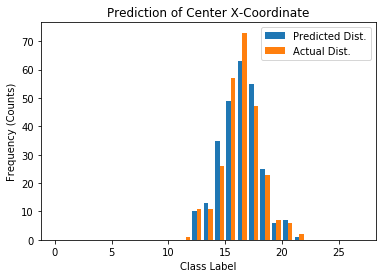

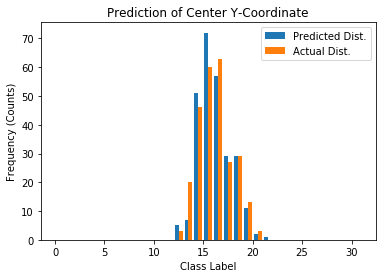

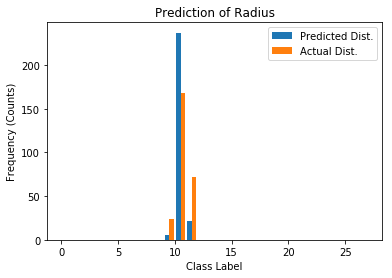

In [17]:
scores_x = model_x(X_val.reshape(X_val.shape[0], 1, X_val.shape[3], X_val.shape[4]))
scores_nparr_x = np.array(scores_x.data)
y_pred_val_x = np.argmax(scores_nparr_x, axis=1)
plt.hist([y_pred_val_x, y_val[:,0]], bins=range(28), label=['Predicted Dist.', 'Actual Dist.'])
plt.title('Prediction of Center X-Coordinate')
plt.xlabel('Class Label')
plt.ylabel('Frequency (Counts)')
plt.legend()
plt.show()

scores_y = model_y(X_val.reshape(X_val.shape[0], 1, X_val.shape[3], X_val.shape[4]))
scores_nparr_y = np.array(scores_y.data)
y_pred_val_y = np.argmax(scores_nparr_y, axis=1)
plt.hist([y_pred_val_y, y_val[:,1]], bins=range(32), label=['Predicted Dist.', 'Actual Dist.'])
plt.title('Prediction of Center Y-Coordinate')
plt.xlabel('Class Label')
plt.ylabel('Frequency (Counts)')
plt.legend()
plt.show()

scores_r = model_r(X_val.reshape(X_val.shape[0], 1, X_val.shape[3], X_val.shape[4]))
scores_nparr_r = np.array(scores_r.data)
y_pred_val_r = np.argmax(scores_nparr_r, axis=1)
plt.hist([y_pred_val_r, y_val[:,2]], bins=range(28), label=['Predicted Dist.', 'Actual Dist.'])
plt.title('Prediction of Radius')
plt.xlabel('Class Label')
plt.ylabel('Frequency (Counts)')
plt.legend()
plt.show()

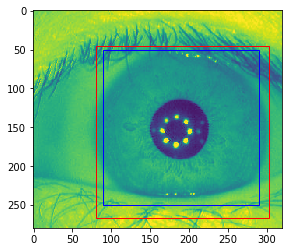

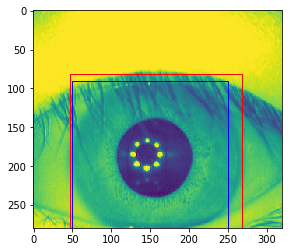

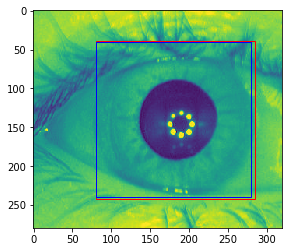

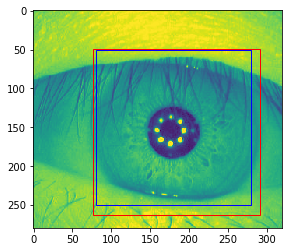

In [24]:
#im = np.array(Image.open('CASIA-Iris-Interval/001/L/S1001L01.jpg'), dtype=np.uint8)

sub = np.random.choice(X_val.shape[0], 4)
for idx in sub:
    
    fig, ax = plt.subplots(1)
    plt.imshow(X_val[idx,0,0,:,:])
    xc, yc, r = y_val_true[idx]
    
    xc_pred = np.argmax(np.array(model_x(X_val[idx]).data)) * 10
    yc_pred = np.argmax(np.array(model_y(X_val[idx]).data)) * 10
    r_pred = np.argmax(np.array(model_r(X_val[idx]).data)) * 10
    
    rect_true = patches.Rectangle((xc-r,yc-r),2*r,2*r,linewidth=1,edgecolor='r',facecolor='none')
    rect_pred = patches.Rectangle((xc_pred-r_pred,yc_pred-r_pred),2*r_pred,2*r_pred,
                                  linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect_true)
    ax.add_patch(rect_pred)
    plt.show()